In [1]:
import keras

import pandas as pd
import numpy as np
import re, string

from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, Dropout, LSTM, GlobalMaxPool1D, Bidirectional
from keras.layers import BatchNormalization, concatenate
from keras.preprocessing import text, sequence
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
import collections

stopwords = set(stopwords.words("english"))

Using TensorFlow backend.


In [2]:
import gensim
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import wordpunct_tokenize

In [3]:
train = pd.read_csv('../proc_data/train_wf.csv')
train.columns = ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'toxic_level', 
                'attack', 'aggression', 'count_sent', 'count_word', 'count_unique_word', 'count_letters', 'count_punctuations', 
                 'count_stopwords', 'mean_word_len', 'word_unique_percent', 'punct_percent', 'total_length', 'capitals', 
                 'caps_vs_length', 'count_exclamation_marks', 'count_question_marks', 'you_count', 'count_badwords']
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_level,attack,...,mean_word_len,word_unique_percent,punct_percent,total_length,capitals,caps_vs_length,count_exclamation_marks,count_question_marks,you_count,count_badwords
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,0.050051,0.097795,...,0.002517,0.953451,0.000329,0.051862,0.003427,0.064293,0.000000,0.004785,0.000000,0.0
1,000103f0d9cfb60f,d aww ! he matches this background colour i am...,0,0,0,0,0,0,0.081845,0.085506,...,0.002774,1.000000,0.001000,0.021225,0.001613,0.071587,0.000202,0.000000,0.000000,0.0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,0.215769,0.142551,...,0.002159,0.928514,0.000202,0.045455,0.000806,0.017205,0.000000,0.000000,0.000000,0.0
3,0001b41b1c6bb37e,more i cannot make any real suggestions on im...,0,0,0,0,0,0,0.138379,0.034277,...,0.002108,0.725444,0.000263,0.124149,0.002218,0.017611,0.000000,0.000000,0.001808,0.0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0.072022,0.020325,...,0.001953,1.000000,0.000545,0.012215,0.000403,0.029917,0.000000,0.004785,0.001808,0.0


In [4]:
test = pd.read_csv('../proc_data/test_wf.csv')
test.columns = ['id', 'comment_text', 'toxic_level', 'attack', 'aggression', 'count_sent', 'count_word', 'count_unique_word', 
                'count_letters', 'count_punctuations', 'count_stopwords', 'mean_word_len', 'word_unique_percent', 
                'punct_percent', 'total_length', 'capitals', 'caps_vs_length', 'count_exclamation_marks', 
                'count_question_marks', 'you_count', 'count_badwords']

test.head()

,id,comment_text,toxic_level,attack,aggression,count_sent,count_word,count_unique_word,count_letters,count_punctuations,...,mean_word_len,word_unique_percent,punct_percent,total_length,capitals,caps_vs_length,count_exclamation_marks,count_question_marks,you_count,count_badwords
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...,0.160755,0.946605,0.946605,0.000000,0.031021,0.074300,0.073215,0.002417,...,0.004126,0.847222,0.000168,0.073215,0.000817,0.010899,0.0,0.0,0.00722,0.004
1,0000247867823ef7,= = from rfc = = the title is fine as it is imo,0.089295,-0.039291,-0.039291,0.002865,0.005170,0.013398,0.010202,0.001208,...,0.003011,0.916667,0.000504,0.010202,0.001430,0.134615,0.0,0.0,0.00000,0.000
2,00013b17ad220c46,= = sources = = zawe ashton on lapland,0.188886,0.048354,0.048354,0.005731,0.005170,0.012180,0.011402,0.001611,...,0.002927,0.833333,0.000671,0.011402,0.000817,0.068966,0.0,0.0,0.00000,0.000
3,00017563c3f7919a,if you have a look back at the source the inf...,0.127194,-0.028451,-0.028451,0.000000,0.016372,0.036541,0.040808,0.001208,...,0.004437,0.789474,0.000159,0.040808,0.000817,0.019512,0.0,0.0,0.00361,0.000
4,00017695ad8997eb,i do not anonymously edit articles at all,0.130050,0.208885,0.208885,0.000000,0.003016,0.008526,0.008002,0.000403,...,0.005018,1.000000,0.000288,0.008002,0.000204,0.024390,0.0,0.0,0.00000,0.000


In [5]:
nb_features = 20000
max_length = 100

Y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
print (Y_train.shape)

simple_tokens = train.comment_text.apply(gensim.utils.simple_preprocess)
phrases = gensim.models.phrases.Phrases(simple_tokens)
tokenizer = gensim.models.phrases.Phraser(phrases)
tokenized_text = list(tokenizer[simple_tokens])
corpus_dict = gensim.corpora.dictionary.Dictionary(tokenized_text)

word2vec = gensim.models.word2vec.Word2Vec(tokenized_text, window=5, size=100, min_count=2, workers=6)
word2vec.wv.most_similar('asshole')

(159571, 6)


[('fuckin', 0.9249674677848816),
 ('faggot', 0.9008384943008423),
 ('prick', 0.8955362439155579),
 ('cunt', 0.8850388526916504),
 ('motherfucker', 0.8831678032875061),
 ('fag', 0.8829270601272583),
 ('wanker', 0.8726450800895691),
 ('bastard', 0.8697882890701294),
 ('dickhead', 0.8682872653007507),
 ('motherfucking', 0.8672178387641907)]

In [6]:
features = np.zeros((len(tokenized_text), word2vec.vector_size))
for i, tokens in enumerate(tokenized_text):
    tokens = [t for t in tokens if t in word2vec.wv.vocab]
    if tokens:
        features[i, :] = np.mean([word2vec.wv[t] / word2vec.wv.vocab[t].count for t in tokens], axis=0)

docs = [[idx + 1 for idx in corpus_dict.doc2idx(doc)]  for doc in tokenized_text]
MAX_SEQ_LEN = 100
X_train = keras.preprocessing.sequence.pad_sequences(docs, maxlen=MAX_SEQ_LEN, truncating='post', value=0)

max_idx = max(c for d in docs for c in d)
print (X_train.shape, max_idx)

(159571, 100) 181396


In [7]:
embeddings = np.array([np.random.normal(size=word2vec.vector_size)]+ 
                      [word2vec.wv[corpus_dict[idx]]
                      if corpus_dict[idx] in word2vec.wv.vocab
                      else np.random.normal(size=word2vec.vector_size)
                      for idx in range(max_idx)])
embeddings.shape

(181397, 100)

In [8]:
inp_text = Input(shape=(max_length, ))

x= Embedding(max_idx + 1, word2vec.vector_size, weights=[embeddings], input_length=MAX_SEQ_LEN)(inp_text)
x = Bidirectional(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)

x = Dense(75, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=[inp_text], outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          18139700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 400)          481600    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 75)                30075     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 456       
Total para

In [9]:
file_path="BiLSTM_W2V_l200_d75.h5"
# model.load_weights(file_path)
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)
callbacks_list = [checkpoint, early] 

hist = model.fit([X_train], Y_train, epochs=3, batch_size=32, validation_split=0.1, shuffle=False, callbacks = callbacks_list)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 4994s - loss: 0.0545 - acc: 0.9802 - val_loss: 0.0484 - val_acc: 0.9820
Epoch 2/3
143613/143613 [==============================] - 4935s - loss: 0.0396 - acc: 0.9844 - val_loss: 0.0467 - val_acc: 0.9820
Epoch 3/3
143613/143613 [==============================] - 4930s - loss: 0.0321 - acc: 0.9870 - val_loss: 0.0514 - val_acc: 0.9807


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


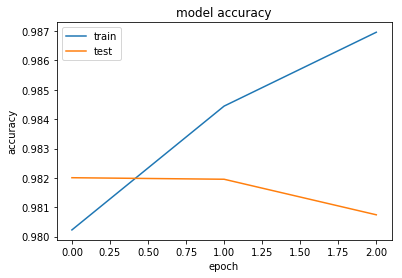

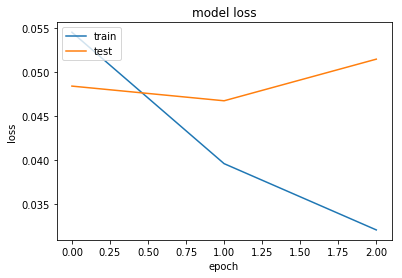

In [13]:
print(hist.history.keys())
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
test.loc[55142,'comment_text'] = 'the'

In [16]:
def comment_to_sequential_input(comment):
    tokens = tokenizer[gensim.utils.simple_preprocess(comment)]
    t_ids = [corpus_dict.token2id[t] + 1 for t in tokens if t in word2vec.wv.vocab and t in corpus_dict.token2id]
    return keras.preprocessing.sequence.pad_sequences([t_ids], maxlen=MAX_SEQ_LEN)[0]

X_test = np.array([comment_to_sequential_input(doc) for doc in test.comment_text])

In [17]:
model.load_weights(file_path)
Y_test = model.predict([X_test], batch_size=1024, verbose=1)

153164/153164 [==============================] - 695s   


In [21]:
sample_submission = pd.read_csv("../data/sample_submission.csv")
sample_submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = Y_test
sample_submission.to_csv("BiLSTM_W2V_l200_d75.csv", index=False)
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999424,3.869563e-01,0.956725,8.080333e-02,0.950889,0.767909
1,0000247867823ef7,0.000414,2.736437e-07,0.000052,2.065949e-07,0.000023,0.000001
2,00013b17ad220c46,0.004937,6.283625e-06,0.000537,4.361037e-06,0.000368,0.000033
3,00017563c3f7919a,0.000520,6.534949e-07,0.000197,1.239547e-06,0.000043,0.000002
4,00017695ad8997eb,0.001879,3.837601e-06,0.000154,6.545710e-06,0.000121,0.000014


In [ ]:
print (file_path)
model.load_weights(file_path)
Y_pred = model.predict([X_train, train[cols_f].as_matrix()], batch_size=1024, verbose=1)